In [30]:
from exp.nb_01 import *
import torch
import torch.nn.functional as F
from torch import nn
import fastai

%matplotlib inline
from matplotlib import pyplot as plt

def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))

def normalize(x, m, s): return (x-m)/s

def stat(x): return x.mean(), x.std()

In [2]:
x_train,y_train,x_valid,y_valid = get_data()
n,m = x_train.shape
c = y_train.max()+1
nh = 64
n,m,c, nh

(50000, 784, tensor(10), 64)

In [3]:
##normalize
mean, std = x_train.mean(), x_train.std()
x_train = normalize(x_train, mean, std)
x_valid = normalize(x_valid, mean, std)
x_train.mean(), x_train.std(), x_valid.mean(), x_valid.std()

(tensor(-7.6999e-06), tensor(1.), tensor(-0.0059), tensor(0.9924))

In [4]:
class Model(torch.nn.Module):
    def __init__(self, ni, nh, no):
        super().__init__()
        self.l1 = nn.Linear(ni, nh)
        self.l2 = nn.Linear(nh, no)
        
    def forward(self, inp):
        return self.l2(F.relu(self.l1(inp)))

In [6]:
model = Model(m, nh, int(c))
model

Model(
  (l1): Linear(in_features=784, out_features=64, bias=True)
  (l2): Linear(in_features=64, out_features=10, bias=True)
)

In [7]:
def acc(pred, targ):
    return (pred.argmax(dim=1) == targ).float().mean()

In [8]:
class Dataset:
    def __init__(self, x, y):
        assert len(x) == len(y)
        self.x, self.y = x, y
    def __getitem__(self, idx):
        if isinstance(idx, slice):
            return Dataset(self.x[idx], self.y[idx])
        else:
            return self.x[idx], self.y[idx]
    def __len__(self):
        return len(self.x)

In [9]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [79]:
class Sampler:
    def __init__(self, ds, bs=64, shuffle=True):
        print('sampler init, n: ', len(ds) )
        self.n, self.bs, self.shuffle = len(ds), bs, shuffle
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        
    def __iter__(self):
        for i in range(0, self.n, self.bs):
            yield self.idxs[i : min(self.n, i+self.bs)]
            

def collate(batch):
    x, y = zip(*batch)
    x, y = torch.stack(x), torch.stack(y)
    return x, y

class Dataloader:
    def __init__(self, ds, bs=64, shuffle=True, collate_fn=collate):
        print('init called')
        self.ds, self.bs, self.shuffle, self.collate_fn = ds, bs, shuffle, collate_fn
        self.sampler = Sampler(self.ds, self.bs, self.shuffle)
        
    def __iter__(self):
        for idxs in self.sampler:
            #print('indexes', idxs)
            yield self.collate_fn([self.ds[i] for i in idxs])
            
    def __len__(self):
        return (len(self.ds)-1)//self.bs + 1

In [80]:
train_dl = Dataloader(train_ds[:10], 4)

init called
sampler init, n:  10


In [87]:
it = iter(train_dl)

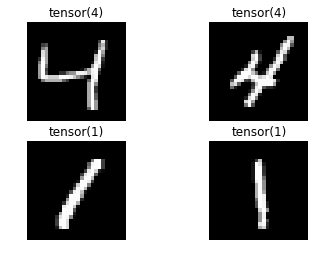

In [89]:
x, y = next(it)
for i in range(len(x)):
    plt.subplot(2, 2, i+1)
    plt.imshow(x[i].view(28,28), cmap='gray')
    plt.axis('off')
    plt.title(str(y[i]))

In [60]:
def getdls(train_ds, test_ds, bs):
    return Dataloader(train_ds, bs), Dataloader(test_ds, 2*bs, False)

In [25]:
class optimizer:
    def __init__(self, params, lr=0.01):
        self.params, self.lr = list(params), lr
    
    def step(self):
        with torch.no_grad():
            for p in self.params:
                p -= p.grad*self.lr
                
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()
    

In [26]:
def fit(model, epochs, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        
        model.train()
        for x, y in train_dl:
            preds = model(x)
            loss = loss_func(preds, y)
            loss.backward()
            
            opt.step()
            opt.zero_grad()
        
        model.eval()
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc  += acc(pred,yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv
            

In [94]:
model = Model(m, nh, 10)
%time fit(model, 20, F.cross_entropy, optimizer(model.parameters(), 0.1), *getdls(train_ds, valid_ds, 64))

init called
sampler init, n:  50000
init called
sampler init, n:  10000
0 tensor(0.1501) tensor(0.9587)
1 tensor(0.1178) tensor(0.9661)
2 tensor(0.1045) tensor(0.9684)
3 tensor(0.0976) tensor(0.9702)
4 tensor(0.0931) tensor(0.9729)
5 tensor(0.0915) tensor(0.9738)
6 tensor(0.0897) tensor(0.9743)
7 tensor(0.0894) tensor(0.9745)
8 tensor(0.0910) tensor(0.9746)
9 tensor(0.0921) tensor(0.9744)
10 tensor(0.0961) tensor(0.9736)
11 tensor(0.0985) tensor(0.9738)
12 tensor(0.1012) tensor(0.9736)
13 tensor(0.1031) tensor(0.9735)
14 tensor(0.1045) tensor(0.9736)
15 tensor(0.1052) tensor(0.9742)
16 tensor(0.1055) tensor(0.9745)
17 tensor(0.1060) tensor(0.9753)
18 tensor(0.1064) tensor(0.9750)
19 tensor(0.1071) tensor(0.9752)
CPU times: user 2min 33s, sys: 391 ms, total: 2min 34s
Wall time: 23.1 s


(tensor(0.1071), tensor(0.9752))